In [246]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 500)

In [0]:
# import 6 feature dataframes
mining = pd.read_csv("https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/06_mining_and_metal_exports.csv")
livestock = pd.read_csv("https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/07_livestock_production_index.csv")
agriculture = pd.read_csv('https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/03_agri_pct_land_area.csv')
urban_population = pd.read_csv('https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/04_urban_population.csv')
gdp = pd.read_csv('https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/13_gdp_growth.csv')
electricity = pd.read_csv('https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/09_elect_power_consumption.csv')

### Target

In [0]:
# import target dataframe
forest_pct = pd.read_csv('https://raw.githubusercontent.com/pragmatizt/BW_Unit3_deforestation/master/01_forest_pct_land_area.csv')

forest_pct = wrangle(forest_pct)

In [249]:
forest_pct

,Country Name,Country Code,Year,Forest area (% of land area)
0,Aruba,ABW,1990,2.33
1,Afghanistan,AFG,1990,2.07
2,Angola,AGO,1990,48.91
3,Albania,ALB,1990,28.79
4,Andorra,AND,1990,34.04
...,...,...,...,...
259,Kosovo,XKX,2016,31.69
260,"Yemen, Rep.",YEM,2016,1.04
261,South Africa,ZAF,2016,7.62
262,Zambia,ZMB,2016,65.20


### Train Dataframe 

In [0]:
def wrangle(df):
  '''
  A function that reformats the World Bank data
  for feature engineering.
  '''
  
  # drop years between 1960-1989
  df.drop(df.iloc[:, 3:34], inplace=True, axis=1)
  
  # drop 2017-2018 as NANs
  df = df.drop(columns=['2017', '2018'])
  
  # deal with nulls
  for col in df.select_dtypes(include=np.number):
    df[col] = df[col].fillna(df[col].median())
   
  # melt
  year = map(str, range(1990, 2017))
  feature = df.iloc[0][2]
  df = pd.concat([pd.melt(df, id_vars=['Country Name', 'Country Code'], value_vars=val, var_name='Year', value_name=feature) for val in year])
  
  return(df)

In [0]:
mining = wrangle(mining)
livestock = wrangle(livestock)
agriculture = wrangle(agriculture)
urban_population = wrangle(urban_population)
gdp = wrangle(gdp)
electricity = wrangle(electricity)

# create list of dfs
feature_dfs = [mining, livestock, agriculture, urban_population, gdp, electricity]

In [0]:
def merge_features(list_dfs):
  '''
  A function that takes tidy dataframes across all features
  and merges them.
  
  Returns in tidy format.
  '''
  
  # use as base for merging
  train = list_dfs.pop(0)
  
  for df in list_dfs:
    train = train.merge(df, on=['Country Name', 'Country Code', 'Year'])
    
  return(train)

In [0]:
features = merge_features(feature_dfs)

In [254]:
# merge features and forest_pct (target)

train = features.merge(forest_pct, on=['Country Name', 'Country Code', 'Year'])

train.head()

,Country Name,Country Code,Year,Ores and metals exports (% of merchandise exports),Livestock production index (2004-2006 = 100),Agricultural land (% of land area),Urban population,GDP per capita growth (annual %),Electric power consumption (kWh per capita),Forest area (% of land area)
0,Aruba,ABW,1990,1.10,67.49,11.11,31273.00,2.09,1237.52,2.33
1,Afghanistan,AFG,1990,2.75,70.69,58.27,2628554.00,1.32,1237.52,2.07
2,Angola,AGO,1990,6.22,70.11,46.04,4400964.00,-6.66,53.17,48.91
3,Albania,ALB,1990,2.75,57.97,40.91,1197222.00,-11.19,552.25,28.79
4,Andorra,AND,1990,2.75,67.49,48.94,51627.00,-0.14,1237.52,34.04


### Predictions

In [0]:
def extend_df(df):
  '''
  A function that takes wrangled data in tidy format and extends predictions 
  of the wrangled dataframe from 2017-2025.
  
  '''
  # Preparing linear regression to make predictions for each country...
  model = LinearRegression()
  
  # Getting list of country codes...
  codes = df['Country Code'].unique()
  
  # Getting list of years where we will predict forest coverage...
  years = [year for year in range(2017, 2026)]
  
  # For-loop to make predictions for each country with first dataset...
  rows = []
  feature = df.columns.tolist()[3]
  
  for code in codes:
      dictionary = {'Country Code': code}
      model.fit(df[df['Country Code'] == code][['Year']],
                df[df['Country Code'] == code][feature])
      for year in years:
          prediction = model.predict([[year]])
          dictionary[str(year)] = prediction[0]
      rows.append(dictionary)
  
  # Making a new dataframe out of the predictions for the first dataset...
  df_predictions = pd.DataFrame(rows)
  
  # Reordering the columns in the dataframe for the first dataset...
  df_predictions = df_predictions[
      ['Country Code'] + [str(year) for year in years]]
  
  
  # melt df_predictions to tidy format
  year = map(str, range(2017, 2026))
  df_predictions = pd.concat([pd.melt(df_predictions, id_vars=['Country Code'], value_vars=val, var_name='Year', value_name=feature) for val in year])

  return(df_predictions)

In [0]:
mining_pred = extend_df(mining)
livestock_pred = extend_df(livestock)
agriculture_pred = extend_df(agriculture)
urban_population_pred = extend_df(urban_population)
gdp_pred = extend_df(gdp)
electricity_pred = extend_df(electricity)

# create list of dfs
feature_dfs_pred = [mining_pred, livestock_pred, agriculture_pred, urban_population_pred, gdp_pred, electricity_pred]

In [0]:
def merge_pred_features(list_dfs_pred):
  '''
  A function that takes predicted dataframes across all features
  and merges them.
  
  Returns a dataframe in tidy format.
  
  ''' 
  # create base df for merging, call it "test"
  test = list_dfs_pred.pop(0)
  
  for df in list_dfs_pred:
    test = test.merge(df, on=['Country Code', 'Year'])
    
  return(test)

In [0]:
test = merge_pred_features(feature_dfs_pred)

## Train model first on 1990-2016

In [0]:
model = LinearRegression()

In [0]:
features = test.columns.tolist()
target = 'Forest area (% of land area)'

In [261]:
X_train

,Country Code_ABW,Country Code_AFG,Country Code_AGO,Country Code_ALB,Country Code_AND,Country Code_ARB,Country Code_ARE,Country Code_ARG,Country Code_ARM,Country Code_ASM,Country Code_ATG,Country Code_AUS,Country Code_AUT,Country Code_AZE,Country Code_BDI,Country Code_BEL,Country Code_BEN,Country Code_BFA,Country Code_BGD,Country Code_BGR,Country Code_BHR,Country Code_BHS,Country Code_BIH,Country Code_BLR,Country Code_BLZ,Country Code_BMU,Country Code_BOL,Country Code_BRA,Country Code_BRB,Country Code_BRN,Country Code_BTN,Country Code_BWA,Country Code_CAF,Country Code_CAN,Country Code_CEB,Country Code_CHE,Country Code_CHI,Country Code_CHL,Country Code_CHN,Country Code_CIV,Country Code_CMR,Country Code_COD,Country Code_COG,Country Code_COL,Country Code_COM,Country Code_CPV,Country Code_CRI,Country Code_CSS,Country Code_CUB,Country Code_CUW,Country Code_CYM,Country Code_CYP,Country Code_CZE,Country Code_DEU,Country Code_DJI,Country Code_DMA,Country Code_DNK,Country Code_DOM,Country Code_DZA,Country Code_EAP,Country Code_EAR,Country Code_EAS,Country Code_ECA,Country Code_ECS,Country Code_ECU,Country Code_EGY,Country Code_EMU,Country Code_ERI,Country Code_ESP,Country Code_EST,Country Code_ETH,Country Code_EUU,Country Code_FCS,Country Code_FIN,Country Code_FJI,Country Code_FRA,Country Code_FRO,Country Code_FSM,Country Code_GAB,Country Code_GBR,Country Code_GEO,Country Code_GHA,Country Code_GIB,Country Code_GIN,Country Code_GMB,Country Code_GNB,Country Code_GNQ,Country Code_GRC,Country Code_GRD,Country Code_GRL,Country Code_GTM,Country Code_GUM,Country Code_GUY,Country Code_HIC,Country Code_HKG,Country Code_HND,Country Code_HPC,Country Code_HRV,Country Code_HTI,Country Code_HUN,Country Code_IBD,Country Code_IBT,Country Code_IDA,Country Code_IDB,Country Code_IDN,Country Code_IDX,Country Code_IMN,Country Code_IND,Country Code_INX,Country Code_IRL,Country Code_IRN,Country Code_IRQ,Country Code_ISL,Country Code_ISR,Country Code_ITA,Country Code_JAM,Country Code_JOR,Country Code_JPN,Country Code_KAZ,Country Code_KEN,Country Code_KGZ,Country Code_KHM,Country Code_KIR,Country Code_KNA,Country Code_KOR,Country Code_KWT,Country Code_LAC,Country Code_LAO,Country Code_LBN,Country Code_LBR,Country Code_LBY,Country Code_LCA,Country Code_LCN,Country Code_LDC,Country Code_LIC,Country Code_LIE,Country Code_LKA,Country Code_LMC,Country Code_LMY,Country Code_LSO,Country Code_LTE,Country Code_LTU,Country Code_LUX,Country Code_LVA,Country Code_MAC,Country Code_MAF,Country Code_MAR,Country Code_MCO,Country Code_MDA,Country Code_MDG,Country Code_MDV,Country Code_MEA,Country Code_MEX,Country Code_MHL,Country Code_MIC,Country Code_MKD,Country Code_MLI,Country Code_MLT,Country Code_MMR,Country Code_MNA,Country Code_MNE,Country Code_MNG,Country Code_MNP,Country Code_MOZ,Country Code_MRT,Country Code_MUS,Country Code_MWI,Country Code_MYS,Country Code_NAC,Country Code_NAM,Country Code_NCL,Country Code_NER,Country Code_NGA,Country Code_NIC,Country Code_NLD,Country Code_NOR,Country Code_NPL,Country Code_NRU,Country Code_NZL,Country Code_OED,Country Code_OMN,Country Code_OSS,Country Code_PAK,Country Code_PAN,Country Code_PER,Country Code_PHL,Country Code_PLW,Country Code_PNG,Country Code_POL,Country Code_PRE,Country Code_PRI,Country Code_PRK,Country Code_PRT,Country Code_PRY,Country Code_PSE,Country Code_PSS,Country Code_PST,Country Code_PYF,Country Code_QAT,Country Code_ROU,Country Code_RUS,Country Code_RWA,Country Code_SAS,Country Code_SAU,Country Code_SDN,Country Code_SEN,Country Code_SGP,Country Code_SLB,Country Code_SLE,Country Code_SLV,Country Code_SMR,Country Code_SOM,Country Code_SRB,Country Code_SSA,Country Code_SSD,Country Code_SSF,Country Code_SST,Country Code_STP,Country Code_SUR,Country Code_SVK,Country Code_SVN,Country Code_SWE,Country Code_SWZ,Country Code_SXM,Country Code_SYC,Country Code_SYR,Country Code_TCA,Country Code_TCD,Country Code_TEA,Country Code_TEC,Country Code_TGO,Country Code_THA,Country Code_TJK,Country Code_TKM,Country Code_TLA,Coun

In [262]:
X_train = train[features]
y_train = train[target]

X_train.Year = X_train.Year.astype(int)

import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [263]:
X_train.head()

,Country Code_ABW,Country Code_AFG,Country Code_AGO,Country Code_ALB,Country Code_AND,Country Code_ARB,Country Code_ARE,Country Code_ARG,Country Code_ARM,Country Code_ASM,Country Code_ATG,Country Code_AUS,Country Code_AUT,Country Code_AZE,Country Code_BDI,Country Code_BEL,Country Code_BEN,Country Code_BFA,Country Code_BGD,Country Code_BGR,Country Code_BHR,Country Code_BHS,Country Code_BIH,Country Code_BLR,Country Code_BLZ,Country Code_BMU,Country Code_BOL,Country Code_BRA,Country Code_BRB,Country Code_BRN,Country Code_BTN,Country Code_BWA,Country Code_CAF,Country Code_CAN,Country Code_CEB,Country Code_CHE,Country Code_CHI,Country Code_CHL,Country Code_CHN,Country Code_CIV,Country Code_CMR,Country Code_COD,Country Code_COG,Country Code_COL,Country Code_COM,Country Code_CPV,Country Code_CRI,Country Code_CSS,Country Code_CUB,Country Code_CUW,Country Code_CYM,Country Code_CYP,Country Code_CZE,Country Code_DEU,Country Code_DJI,Country Code_DMA,Country Code_DNK,Country Code_DOM,Country Code_DZA,Country Code_EAP,Country Code_EAR,Country Code_EAS,Country Code_ECA,Country Code_ECS,Country Code_ECU,Country Code_EGY,Country Code_EMU,Country Code_ERI,Country Code_ESP,Country Code_EST,Country Code_ETH,Country Code_EUU,Country Code_FCS,Country Code_FIN,Country Code_FJI,Country Code_FRA,Country Code_FRO,Country Code_FSM,Country Code_GAB,Country Code_GBR,Country Code_GEO,Country Code_GHA,Country Code_GIB,Country Code_GIN,Country Code_GMB,Country Code_GNB,Country Code_GNQ,Country Code_GRC,Country Code_GRD,Country Code_GRL,Country Code_GTM,Country Code_GUM,Country Code_GUY,Country Code_HIC,Country Code_HKG,Country Code_HND,Country Code_HPC,Country Code_HRV,Country Code_HTI,Country Code_HUN,Country Code_IBD,Country Code_IBT,Country Code_IDA,Country Code_IDB,Country Code_IDN,Country Code_IDX,Country Code_IMN,Country Code_IND,Country Code_INX,Country Code_IRL,Country Code_IRN,Country Code_IRQ,Country Code_ISL,Country Code_ISR,Country Code_ITA,Country Code_JAM,Country Code_JOR,Country Code_JPN,Country Code_KAZ,Country Code_KEN,Country Code_KGZ,Country Code_KHM,Country Code_KIR,Country Code_KNA,Country Code_KOR,Country Code_KWT,Country Code_LAC,Country Code_LAO,Country Code_LBN,Country Code_LBR,Country Code_LBY,Country Code_LCA,Country Code_LCN,Country Code_LDC,Country Code_LIC,Country Code_LIE,Country Code_LKA,Country Code_LMC,Country Code_LMY,Country Code_LSO,Country Code_LTE,Country Code_LTU,Country Code_LUX,Country Code_LVA,Country Code_MAC,Country Code_MAF,Country Code_MAR,Country Code_MCO,Country Code_MDA,Country Code_MDG,Country Code_MDV,Country Code_MEA,Country Code_MEX,Country Code_MHL,Country Code_MIC,Country Code_MKD,Country Code_MLI,Country Code_MLT,Country Code_MMR,Country Code_MNA,Country Code_MNE,Country Code_MNG,Country Code_MNP,Country Code_MOZ,Country Code_MRT,Country Code_MUS,Country Code_MWI,Country Code_MYS,Country Code_NAC,Country Code_NAM,Country Code_NCL,Country Code_NER,Country Code_NGA,Country Code_NIC,Country Code_NLD,Country Code_NOR,Country Code_NPL,Country Code_NRU,Country Code_NZL,Country Code_OED,Country Code_OMN,Country Code_OSS,Country Code_PAK,Country Code_PAN,Country Code_PER,Country Code_PHL,Country Code_PLW,Country Code_PNG,Country Code_POL,Country Code_PRE,Country Code_PRI,Country Code_PRK,Country Code_PRT,Country Code_PRY,Country Code_PSE,Country Code_PSS,Country Code_PST,Country Code_PYF,Country Code_QAT,Country Code_ROU,Country Code_RUS,Country Code_RWA,Country Code_SAS,Country Code_SAU,Country Code_SDN,Country Code_SEN,Country Code_SGP,Country Code_SLB,Country Code_SLE,Country Code_SLV,Country Code_SMR,Country Code_SOM,Country Code_SRB,Country Code_SSA,Country Code_SSD,Country Code_SSF,Country Code_SST,Country Code_STP,Country Code_SUR,Country Code_SVK,Country Code_SVN,Country Code_SWE,Country Code_SWZ,Country Code_SXM,Country Code_SYC,Country Code_SYR,Country Code_TCA,Country Code_TCD,Country Code_TEA,Country Code_TEC,Country Code_TGO,Country Code_THA,Country Code_TJK,Country Code_TKM,Country Code_TLA,Coun

In [264]:
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Test (Get Predictions)

In [0]:
X_test = test[features]
X_test.Year = X_test.Year.astype(int)

X_test = encoder.transform(X_test)

In [0]:
y_pred = model.predict(X_test)

In [267]:
y_pred

array([ 1.91417921,  1.7846444 , 46.92353218, ...,  6.96801187,
       66.49936001, 45.02961566])

In [268]:
test['Forest area (% of land area)'] = pd.Series(y_pred)
test.head(1000)

,Country Code,Year,Ores and metals exports (% of merchandise exports),Livestock production index (2004-2006 = 100),Agricultural land (% of land area),Urban population,GDP per capita growth (annual %),Electric power consumption (kWh per capita),Forest area (% of land area)
0,ABW,2017,4.12,122.55,11.11,47793.06,-1.31,1901.30,1.91
1,AFG,2017,2.02,109.57,58.04,8663347.15,4.48,1901.30,1.78
2,AGO,2017,2.04,142.03,47.28,17876481.97,4.29,190.49,46.92
3,ALB,2017,15.30,118.57,43.31,1657050.46,6.94,1851.69,27.82
4,AND,2017,3.62,122.55,40.20,76838.59,0.47,1901.30,34.27
...,...,...,...,...,...,...,...,...,...
995,SAU,2020,0.52,152.06,90.28,28196031.35,0.07,6893.70,-2.00
996,SDN,2020,2.40,136.23,38.22,14319188.62,5.42,124.52,30.39
997,SEN,2020,3.17,138.78,46.79,7101712.32,3.20,170.80,44.84
998,SGP,2020,1.07,-24.97,0.53,6002891.30,2.11,7236.76,25.89


In [0]:
# download predictions result as a csv

from google.colab import files
test.to_csv('predictions.csv')
files.download('predictions.csv')

## Robustness checks

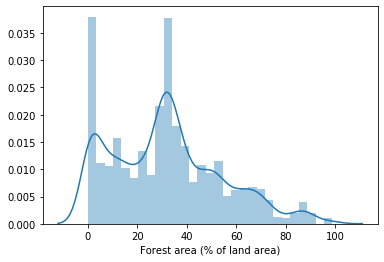

In [270]:
ax = sns.distplot(train['Forest area (% of land area)'])

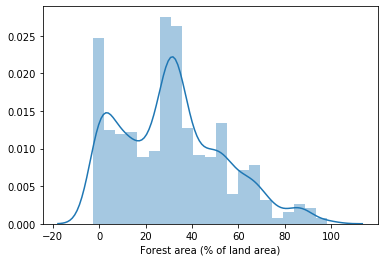

In [271]:
ax = sns.distplot(test['Forest area (% of land area)'])